In [1]:
# logistic regression classification modeling

In [2]:
## ** INPUT REQUIRED **
# add filtering option for backtest or live predictions

In [3]:
# installations
!pip install fpdf


In [4]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import normaltest

from fpdf import FPDF
from datetime import datetime
import re

In [5]:
# Load the raw dataset
wr_df_raw = pd.read_csv("wr_df_stats_features_imputations.csv")

In [6]:
# Create working copy
wr_df = wr_df_raw.copy()

In [7]:
# --- Inspect the hit_value_dk target column --- #
print("🔍 Value Counts:")
print(wr_df["hit_value_dk"].value_counts(dropna=False))

print("\n🔍 Data Type:", wr_df["hit_value_dk"].dtype)
print("❓ Missing Values:", wr_df["hit_value_dk"].isnull().sum())

proportion = wr_df["hit_value_dk"].mean()
print(f"\n✅ Proportion of hits (1's): {proportion:.2%}")

🔍 Value Counts:
hit_value_dk
False    11026
True      6423
Name: count, dtype: int64

🔍 Data Type: bool
❓ Missing Values: 0

✅ Proportion of hits (1's): 36.81%


In [8]:
# Option 1: modify the dataframe to filter players with targets and receptions per season

# Calculate season totals
season_totals = (
    wr_df.groupby(["player_display_name", "season"])[["targets", "receptions"]]
    .sum()
    .reset_index()
)

# Keep player-seasons with at least 5 total targets or receptions
valid_ids = season_totals[
    (season_totals["targets"] >= 5) | (season_totals["receptions"] >= 5)
][["player_display_name", "season"]]

# Merge to filter wr_df
wr_df = wr_df.merge(valid_ids, on=["player_display_name", "season"], how="inner")


In [9]:
# Option 2: modify the dataframe to filter players with targets and receptions per game
# min_tgts = 1
# min_rec = 1
# wr_df = wr_df[(wr_df["targets"] >= min_tgts) | (wr_df["receptions"] >= min_rec)].copy()


In [10]:
# helper function - 
# -test normality
# -search for corresponding z-score and is_missing column
# -recommend using base feature or z-scored feature

def evaluate_feature_for_zscore(features, alpha=0.05):
    if isinstance(features, str):
        features = [features]
    elif isinstance(features, dict):
        features = list(features.values())

    results = []

    for base_feature in features:
        print(f"🔍 Evaluating feature: {base_feature}")

        # Normality test
        data = wr_df[base_feature].dropna()
        stat, p = normaltest(data)
        is_normal = p > alpha
        print(f" - Normality test p-value: {p:.4f} → {'✅ Probably normal' if is_normal else '❌ Not normal'}")

        # Z-score and missing flag checks
        z_feature = f"{base_feature}_z"
        base_flag = f"is_missing_{base_feature}"
        z_flag = f"is_missing_{z_feature}"

        has_z = z_feature in wr_df.columns
        has_base_flag = base_flag in wr_df.columns
        has_z_flag = z_flag in wr_df.columns

        print(f" - Z-score version: {'✅ Found' if has_z else '❌ Not found'}")
        print(f" - Missing flag for base: {base_flag if has_base_flag else '❌ Not found'}")
        print(f" - Missing flag for z: {z_flag if has_z_flag else '❌ Not found'}")

        if is_normal and has_z:
            recommendation = f"✅ Use Z-score version: {z_feature}"
            recommended_feature = z_feature
            flag_used = z_flag if has_z_flag else None
        else:
            recommendation = f"✅ Use Base version: {base_feature}"
            recommended_feature = base_feature
            flag_used = base_flag if has_base_flag else None

        print(f"📌 Recommendation: {recommendation}")
        if flag_used:
            print(f"⚠️  Include missingness flag: {flag_used}")
        print("-" * 60)

        results.append({
            "base_feature": base_feature,
            "use_z": is_normal and has_z,
            "recommended_feature": recommended_feature,
            "missing_flag": flag_used
        })

    return results


In [11]:
# Match imputation flags to features  - "is_missing"
# Note: the model needs to understand when we imputed so add the corresponding boolean column 

# Select Feature Columns
features_base = [
    "targets",
    "receptions",
    "rolling_fpts_diff_dk",
    "value_ratio_dk_log",
]

evaluate_feature_for_zscore(features_base)

🔍 Evaluating feature: targets
 - Normality test p-value: 0.0000 → ❌ Not normal
 - Z-score version: ❌ Not found
 - Missing flag for base: ❌ Not found
 - Missing flag for z: ❌ Not found
📌 Recommendation: ✅ Use Base version: targets
------------------------------------------------------------
🔍 Evaluating feature: receptions
 - Normality test p-value: 0.0000 → ❌ Not normal
 - Z-score version: ❌ Not found
 - Missing flag for base: ❌ Not found
 - Missing flag for z: ❌ Not found
📌 Recommendation: ✅ Use Base version: receptions
------------------------------------------------------------
🔍 Evaluating feature: rolling_fpts_diff_dk
 - Normality test p-value: 0.0000 → ❌ Not normal
 - Z-score version: ❌ Not found
 - Missing flag for base: is_missing_rolling_fpts_diff_dk
 - Missing flag for z: ❌ Not found
📌 Recommendation: ✅ Use Base version: rolling_fpts_diff_dk
⚠️  Include missingness flag: is_missing_rolling_fpts_diff_dk
------------------------------------------------------------
🔍 Evaluating 

[{'base_feature': 'targets',
  'use_z': False,
  'recommended_feature': 'targets',
  'missing_flag': None},
 {'base_feature': 'receptions',
  'use_z': False,
  'recommended_feature': 'receptions',
  'missing_flag': None},
 {'base_feature': 'rolling_fpts_diff_dk',
  'use_z': False,
  'recommended_feature': 'rolling_fpts_diff_dk',
  'missing_flag': 'is_missing_rolling_fpts_diff_dk'},
 {'base_feature': 'value_ratio_dk_log',
  'use_z': False,
  'recommended_feature': 'value_ratio_dk_log',
  'missing_flag': None}]

In [12]:
### *** EXTREMELY IMPORTANT *** ###
# Ensures temporal calculations or rows are correct and no data leakage
# predictions for row n computed from rows < n

# Helper function to create a model-ready dataframe with proper lagging
def create_modeling_dataframe(df, features_to_lag, group_cols=["player_display_name", "season"]):
 
    df_lagged = df.copy()
    
    for feature in features_to_lag:
        if feature in df_lagged.columns:
            df_lagged[feature] = (
                df_lagged
                .groupby(group_cols)[feature]
                .shift(1)
            )
        else:
            print(f"⚠️ Feature '{feature}' not found in dataframe — skipping.")
    
    return df_lagged

In [13]:
# Generate the lagged modeling dataframe
wr_model_df = create_modeling_dataframe(wr_df, features_base)

In [14]:
## Important: define your target (y-variable) and predictor variables (features)
# subset features from df into a temporary X variable
X = wr_model_df[features_base].copy()
y = wr_model_df["hit_value_dk"].copy()


In [15]:
# setup the train-test split
# train on seasons < 2023
# validation on season 2023
# final test on 2024

# Mask for seasons (from wr_model_df!)
mask_2024 = wr_model_df["season"] == 2024
mask_2023 = wr_model_df["season"] == 2023
mask_pre_2023 = wr_model_df["season"] < 2023

# Full null check mask
mask_all_valid = X.notnull().all(axis=1) & y.notnull()

# Training set: Pre-2023
mask_train = mask_all_valid & mask_pre_2023
X_train = X[mask_train]
y_train = y[mask_train]

# Validation set: 2023
mask_val = mask_all_valid & mask_2023
X_val = X[mask_val]
y_val = y[mask_val]

# Final test set: 2024
mask_test = mask_all_valid & mask_2024
X_test_final = X[mask_test]
y_test_final = y[mask_test]

# Summary
print(f"Training samples:      {len(X_train)}")
print(f"Validation (2023):     {len(X_val)}")
print(f"Final Test (2024):     {len(X_test_final)}")

print("\nClass Distribution:")
print("Train:\n", y_train.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))
print("Val:\n", y_val.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))
print("Test:\n", y_test_final.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))


Training samples:      11343
Validation (2023):     2142
Final Test (2024):     1954

Class Distribution:
Train:
 hit_value_dk
False    61.52%
True     38.48%
Name: proportion, dtype: object
Val:
 hit_value_dk
False    63.49%
True     36.51%
Name: proportion, dtype: object
Test:
 hit_value_dk
False    63.56%
True     36.44%
Name: proportion, dtype: object


In [16]:
# Import and Initialize the Model
# Fit a Baseline Regularized Model (L2, C=1.0)

# Create a logistic regression model object
logreg_model = LogisticRegression(
    penalty="l2",
    C=1.0,  # Regularization strength (lower = more regularization)
    solver="lbfgs",
    class_weight="balanced",
    max_iter=1000,
    random_state=42
)


# Fit the model on training data
logreg_model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [17]:
# Grid Search for Best C

param_grid = {
    "C": [0.01, 0.1, 1, 10, 100]
}

grid = GridSearchCV(
    estimator=LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    ),
    param_grid=param_grid,
    scoring="f1",  # Or 'roc_auc' depending on your goal
    cv=5
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_


In [18]:
# Evaluate both models
print("Baseline model (C=1):")
print(classification_report(y_val, logreg_model.predict(X_val)))

print("\nTuned model:")
print(classification_report(y_val, best_model.predict(X_val)))


Baseline model (C=1):
              precision    recall  f1-score   support

       False       0.72      0.64      0.67      1360
        True       0.47      0.56      0.51       782

    accuracy                           0.61      2142
   macro avg       0.59      0.60      0.59      2142
weighted avg       0.63      0.61      0.61      2142


Tuned model:
              precision    recall  f1-score   support

       False       0.72      0.64      0.67      1360
        True       0.47      0.56      0.51       782

    accuracy                           0.61      2142
   macro avg       0.59      0.60      0.59      2142
weighted avg       0.63      0.61      0.61      2142



In [19]:
# View and Interpret the Model Coefficients
# View learned coefficients with their corresponding feature names
coefficients = pd.Series(
    logreg_model.coef_[0],
    index=X_train.columns
).sort_values(ascending=False)

print("🔎 Logistic Regression Coefficients:")
print(coefficients)

coefficients = pd.Series(best_model.coef_[0], index=X_train.columns).sort_values()


🔎 Logistic Regression Coefficients:
value_ratio_dk_log      0.669090
targets                 0.084811
rolling_fpts_diff_dk    0.007438
receptions             -0.049959
dtype: float64


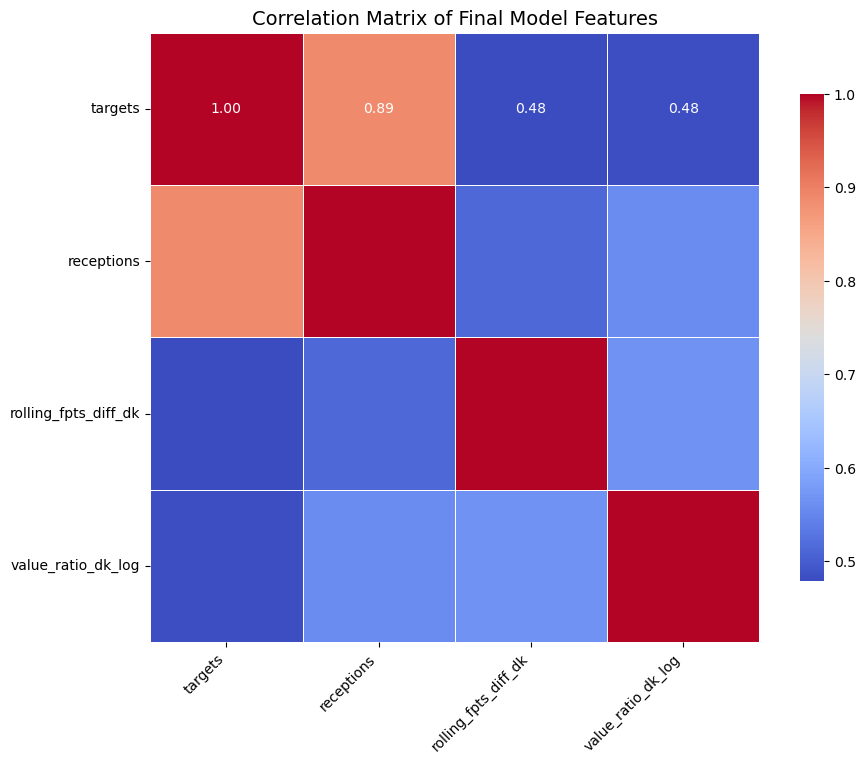

⚠️ Highly Correlated Pairs (|r| > 0.75):


,targets,receptions,rolling_fpts_diff_dk,value_ratio_dk_log
targets,NaN,0.889945,NaN,NaN
receptions,0.889945,NaN,NaN,NaN
rolling_fpts_diff_dk,NaN,NaN,NaN,NaN
value_ratio_dk_log,NaN,NaN,NaN,NaN


In [20]:
# 📉 Correlation Matrix Among Features
# 🕵️ Spot collinearity and detect proxy behavior

# 📊 Correlation Matrix Among Final Model Features
# 🔁 Recalculate correlation matrix using final features
corr_matrix = wr_model_df[features_base].dropna().corr()

# ❌ Remove the mask to show full square matrix
# ✅ Increase figure size and layout margins to prevent cutoff
plt.figure(figsize=(10, 8))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Matrix of Final Model Features", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout(pad=2.0)
plt.show()

# 🔍 Find high-correlation pairs
threshold = 0.75
high_corr = corr_matrix.abs() > threshold
print("⚠️ Highly Correlated Pairs (|r| > 0.75):")
display(corr_matrix[high_corr & ~np.eye(len(corr_matrix), dtype=bool)])


In [21]:
# modify the feature base based on modeling and correlation analysis
features_base = [f for f in features_base if f != "receptions"]


In [22]:
# explore more features
candidate_features = [
    "catch_percentage",
    "catch_percentage_scaled",
    "catch_percentage_scaled_z",
    "fpts_3wk_avg",
    "avg_cushion",
    "avg_separation",
    "avg_intended_air_yards",
    "percent_share_of_intended_air_yards"
]

# Count non-null values
wr_df[candidate_features].notnull().sum().sort_values(ascending=False)


catch_percentage                       16949
catch_percentage_scaled                16949
catch_percentage_scaled_z              16949
fpts_3wk_avg                           16949
avg_cushion                            16949
avg_separation                         16949
avg_intended_air_yards                 16949
percent_share_of_intended_air_yards    16949
dtype: int64

In [23]:
# test candidate features for normality
evaluate_feature_for_zscore(candidate_features)


🔍 Evaluating feature: catch_percentage
 - Normality test p-value: 0.0000 → ❌ Not normal
 - Z-score version: ❌ Not found
 - Missing flag for base: ❌ Not found
 - Missing flag for z: ❌ Not found
📌 Recommendation: ✅ Use Base version: catch_percentage
------------------------------------------------------------
🔍 Evaluating feature: catch_percentage_scaled
 - Normality test p-value: 0.0000 → ❌ Not normal
 - Z-score version: ✅ Found
 - Missing flag for base: ❌ Not found
 - Missing flag for z: ❌ Not found
📌 Recommendation: ✅ Use Base version: catch_percentage_scaled
------------------------------------------------------------
🔍 Evaluating feature: catch_percentage_scaled_z
 - Normality test p-value: 0.0000 → ❌ Not normal
 - Z-score version: ❌ Not found
 - Missing flag for base: ❌ Not found
 - Missing flag for z: ❌ Not found
📌 Recommendation: ✅ Use Base version: catch_percentage_scaled_z
------------------------------------------------------------
🔍 Evaluating feature: fpts_3wk_avg
 - Normali

[{'base_feature': 'catch_percentage',
  'use_z': False,
  'recommended_feature': 'catch_percentage',
  'missing_flag': None},
 {'base_feature': 'catch_percentage_scaled',
  'use_z': False,
  'recommended_feature': 'catch_percentage_scaled',
  'missing_flag': None},
 {'base_feature': 'catch_percentage_scaled_z',
  'use_z': False,
  'recommended_feature': 'catch_percentage_scaled_z',
  'missing_flag': None},
 {'base_feature': 'fpts_3wk_avg',
  'use_z': False,
  'recommended_feature': 'fpts_3wk_avg',
  'missing_flag': 'is_missing_fpts_3wk_avg'},
 {'base_feature': 'avg_cushion',
  'use_z': False,
  'recommended_feature': 'avg_cushion',
  'missing_flag': 'is_missing_avg_cushion'},
 {'base_feature': 'avg_separation',
  'use_z': False,
  'recommended_feature': 'avg_separation',
  'missing_flag': 'is_missing_avg_separation'},
 {'base_feature': 'avg_intended_air_yards',
  'use_z': False,
  'recommended_feature': 'avg_intended_air_yards',
  'missing_flag': 'is_missing_avg_intended_air_yards'},
 

In [24]:
# Helper for Candidate Feature Evaluation
# -Check correlation among candidates
# -Check correlation with existing features_base
# -Identify and remove near-duplicate features (e.g., > 0.98 corr)
# -Evaluate predictive signal against target
# -Recommend new features to include

def evaluate_candidate_features(df, candidates, features_base, target, corr_thresh=0.9, signal_thresh=0.05):

    print(f"🔍 Evaluating {len(candidates)} candidate features...")

    results = {
        "high_corr_among_candidates": [],
        "high_corr_with_base": [],
        "low_signal": [],
        "recommended_features": []
    }

    # Correlation among candidates
    cand_corr = df[candidates].corr()
    for i, col_i in enumerate(candidates):
        for j, col_j in enumerate(candidates):
            if i < j and abs(cand_corr.loc[col_i, col_j]) >= corr_thresh:
                results["high_corr_among_candidates"].append((col_i, col_j, cand_corr.loc[col_i, col_j]))

    # Correlation with existing features
    all_features = features_base + candidates
    full_corr = df[all_features].corr()
    for c in candidates:
        for f in features_base:
            if abs(full_corr.loc[c, f]) >= corr_thresh:
                results["high_corr_with_base"].append((c, f, full_corr.loc[c, f]))

    # Evaluate predictive power
    corr_with_target = df[candidates].corrwith(df[target])
    for c in candidates:
        if abs(corr_with_target[c]) < signal_thresh:
            results["low_signal"].append((c, corr_with_target[c]))

    # Recommend features that are:
    # - Not highly correlated with other candidates or base features
    # - Have sufficient signal
    excluded = set([x[0] for x in results["high_corr_among_candidates"]] +
                   [x[0] for x in results["high_corr_with_base"]] +
                   [x[0] for x in results["low_signal"]])
    
    for c in candidates:
        if c not in excluded:
            results["recommended_features"].append(c)

    # Print summary
    print(f"🔗 High correlation among candidates (>{corr_thresh}): {len(results['high_corr_among_candidates'])}")
    print(f"🔗 High correlation with base features (>{corr_thresh}): {len(results['high_corr_with_base'])}")
    print(f"📉 Low predictive signal (<{signal_thresh} correlation with target): {len(results['low_signal'])}")
    print(f"✅ Recommended features to add: {results['recommended_features']}")

    return results


In [25]:
results = evaluate_candidate_features(
    df=wr_df,
    candidates=candidate_features,
    features_base=features_base,
    target='hit_value_dk',  
    corr_thresh=0.9,
    signal_thresh=0.05
)


🔍 Evaluating 8 candidate features...
🔗 High correlation among candidates (>0.9): 4
🔗 High correlation with base features (>0.9): 0
📉 Low predictive signal (<0.05 correlation with target): 0
✅ Recommended features to add: ['catch_percentage_scaled_z', 'fpts_3wk_avg', 'avg_separation', 'avg_intended_air_yards', 'percent_share_of_intended_air_yards']


In [26]:
# include new features and and "is_missing_" flags
new_features = [
    'fpts_3wk_avg',
    'is_missing_fpts_3wk_avg',
    'avg_separation',
    'is_missing_avg_separation',
    'avg_intended_air_yards',
    'is_missing_avg_intended_air_yards',
    'percent_share_of_intended_air_yards',
    'is_missing_percent_share_of_intended_air_yards'
]


In [27]:
# add the new features to the base features
features_base = list(set(features_base + new_features))


In [28]:
# Regenerate the lagged modeling DataFrame
wr_model_df = create_modeling_dataframe(wr_df, features_base)


In [29]:
## Important: re-define  target (y-variable) and predictor variables (features) after correlation analysis

# subset features from df into a temporary X variable
X = wr_model_df[features_base].copy()
y = wr_model_df["hit_value_dk"].copy()


In [30]:
# Recreate your train / val / test splits

mask_2024 = wr_model_df["season"] == 2024
mask_2023 = wr_model_df["season"] == 2023
mask_pre_2023 = wr_model_df["season"] < 2023

mask_all_valid = X.notnull().all(axis=1) & y.notnull()

mask_train = mask_all_valid & mask_pre_2023
X_train = X[mask_train]
y_train = y[mask_train]

mask_val = mask_all_valid & mask_2023
X_val = X[mask_val]
y_val = y[mask_val]

mask_test = mask_all_valid & mask_2024
X_test_final = X[mask_test]
y_test_final = y[mask_test]


In [31]:
## retrain and fit the model after modifying features ##

# Create a logistic regression model with moderate regularization
logreg_model = LogisticRegression(
    penalty="l2",            # L2 regularization
    C=1.0,                   # Regularization strength
    solver="lbfgs",          # Recommended for small to medium datasets
    class_weight="balanced",# Handle class imbalance
    max_iter=1000,
    random_state=42
)

# Fit on training data
logreg_model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [32]:
## retrain and fit the model after modifying features ##

# Define parameter grid
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100]
}

# Setup grid search
grid = GridSearchCV(
    estimator=LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    ),
    param_grid=param_grid,
    scoring="f1",  # Or 'roc_auc' depending on your metric priority
    cv=5
)

# Fit grid search on training data
grid.fit(X_train, y_train)

# Extract best model
best_model = grid.best_estimator_


In [33]:
# compare the baseline vs. tuned model on the validation set

print("📊 Baseline model (C=1):")
print(classification_report(y_val, logreg_model.predict(X_val)))

print("\n✅ Tuned model (best C):")
print(classification_report(y_val, best_model.predict(X_val)))


📊 Baseline model (C=1):
              precision    recall  f1-score   support

       False       0.73      0.61      0.67      1360
        True       0.47      0.60      0.53       782

    accuracy                           0.61      2142
   macro avg       0.60      0.61      0.60      2142
weighted avg       0.63      0.61      0.62      2142


✅ Tuned model (best C):
              precision    recall  f1-score   support

       False       0.73      0.61      0.67      1360
        True       0.47      0.60      0.53       782

    accuracy                           0.61      2142
   macro avg       0.60      0.61      0.60      2142
weighted avg       0.63      0.61      0.62      2142



In [34]:
# View and interpret the model coefficients based on the expanded features list
coefficients = pd.Series(
    best_model.coef_[0],
    index=X_train.columns
).sort_values(ascending=False)

print("🔍 Logistic Regression Coefficients (sorted by influence):")
display(coefficients)


🔍 Logistic Regression Coefficients (sorted by influence):


value_ratio_dk_log                                0.700987
fpts_3wk_avg                                      0.031062
targets                                           0.020562
percent_share_of_intended_air_yards               0.001878
is_missing_avg_intended_air_yards                 0.000000
is_missing_fpts_3wk_avg                           0.000000
is_missing_percent_share_of_intended_air_yards    0.000000
avg_intended_air_yards                           -0.005202
rolling_fpts_diff_dk                             -0.023124
avg_separation                                   -0.050922
is_missing_avg_separation                        -0.369227
dtype: float64

In [35]:
# Drop value_ratio_dk_log and all is_missing_* flags from features_base
features_base = [
    f for f in features_base
    if f != "value_ratio_dk_log" and not f.startswith("is_missing_")
]


In [36]:
# Recreate wr_model_df with lagged features
wr_model_df = create_modeling_dataframe(wr_df, features_base)


In [37]:
# Redefine X and y
X = wr_model_df[features_base].copy()
y = wr_model_df["hit_value_dk"].copy()


In [38]:
# Recreate masks
mask_2024 = wr_model_df["season"] == 2024
mask_2023 = wr_model_df["season"] == 2023
mask_pre_2023 = wr_model_df["season"] < 2023

# Full null check
mask_all_valid = X.notnull().all(axis=1) & y.notnull()

# Training
mask_train = mask_all_valid & mask_pre_2023
X_train = X[mask_train]
y_train = y[mask_train]

# Validation
mask_val = mask_all_valid & mask_2023
X_val = X[mask_val]
y_val = y[mask_val]

# Final Test
mask_test = mask_all_valid & mask_2024
X_test_final = X[mask_test]
y_test_final = y[mask_test]


In [39]:
# Train baseline logistic regression
logreg_model = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    class_weight="balanced",
    max_iter=1000,
    random_state=42
)
logreg_model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [40]:
# Define hyperparameter grid
param_grid = { "C": [0.01, 0.1, 1, 10, 100] }

grid = GridSearchCV(
    estimator=LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    ),
    param_grid=param_grid,
    scoring="f1",
    cv=5
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_


In [41]:
# Compare baseline vs tuned
print("📊 Baseline model (C=1):")
print(classification_report(y_val, logreg_model.predict(X_val)))

print("\n✅ Tuned model (best C):")
print(classification_report(y_val, best_model.predict(X_val)))


📊 Baseline model (C=1):
              precision    recall  f1-score   support

       False       0.71      0.64      0.67      1360
        True       0.46      0.54      0.50       782

    accuracy                           0.60      2142
   macro avg       0.59      0.59      0.59      2142
weighted avg       0.62      0.60      0.61      2142


✅ Tuned model (best C):
              precision    recall  f1-score   support

       False       0.71      0.64      0.67      1360
        True       0.46      0.54      0.50       782

    accuracy                           0.60      2142
   macro avg       0.59      0.59      0.59      2142
weighted avg       0.62      0.60      0.61      2142



In [42]:
# View coefficients of tuned model
coefficients = pd.Series(
    best_model.coef_[0],
    index=X_train.columns
).sort_values(ascending=False)

print("🔍 Logistic Regression Coefficients (sorted by influence):")
display(coefficients)


🔍 Logistic Regression Coefficients (sorted by influence):


targets                                0.052451
rolling_fpts_diff_dk                   0.030082
fpts_3wk_avg                           0.016008
avg_separation                         0.015504
avg_intended_air_yards                 0.007778
percent_share_of_intended_air_yards    0.001482
dtype: float64

In [43]:
# Predict labels and probabilities on test set
y_pred_test = best_model.predict(X_test_final)
y_proba_test = best_model.predict_proba(X_test_final)[:, 1]

# Print classification report
print("📅 Final Test Set (2024) Evaluation:")
print(classification_report(y_test_final, y_pred_test))

# AUC
auc_test = roc_auc_score(y_test_final, y_proba_test)
print(f"🧮 ROC AUC (2024): {auc_test:.3f}")


📅 Final Test Set (2024) Evaluation:
              precision    recall  f1-score   support

       False       0.72      0.64      0.68      1242
        True       0.47      0.56      0.51       712

    accuracy                           0.61      1954
   macro avg       0.59      0.60      0.59      1954
weighted avg       0.63      0.61      0.62      1954

🧮 ROC AUC (2024): 0.638


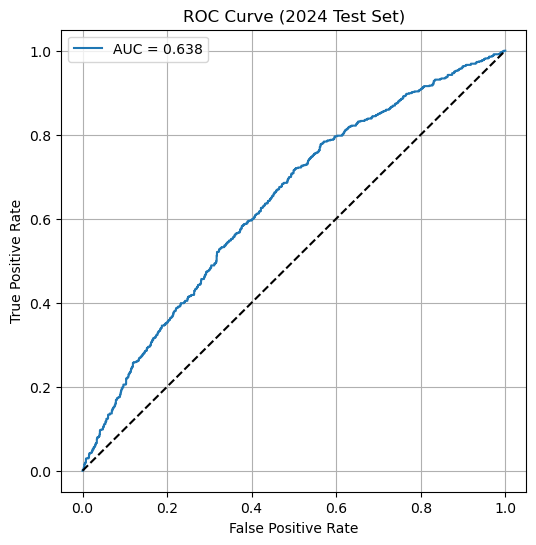

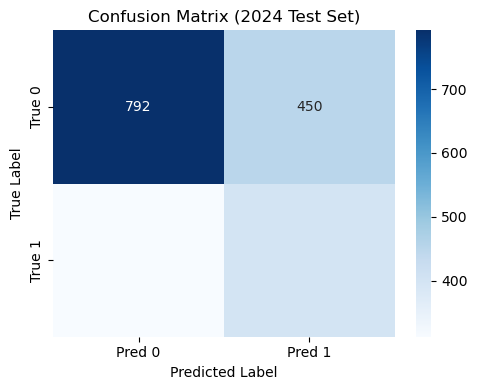

In [44]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_final, y_proba_test)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_test:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (2024 Test Set)")
plt.legend()
plt.grid()
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_test_final, y_pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (2024 Test Set)")
plt.tight_layout()
plt.show()


In [45]:
### End: experimental logistic regression modeling  ###

In [46]:
### Begin: value-based logistic regression classifier model  ###

In [47]:
# model 2: value model with the same target but new features

# Define cleaned value-based feature list for modeling
value_based_features = [
    'Total', 'dk_salary',
    'value_ratio_dk', 'value_ratio_dk_3wk', 'value_ratio_dk_5wk', 'value_ratio_dk_7wk',
    'value_ratio_dk_90th_percentile_3wk', 'value_ratio_dk_90th_percentile_5wk',
    'value_ratio_dk_90th_percentile_7wk',
   
]

In [48]:
# model 2: value-based model

# apply the temporal lagging function
wr_model_value_df = create_modeling_dataframe(wr_df, value_based_features)


In [49]:
# model 2: value-based model

# define your target variable and predictors
X = wr_model_value_df[value_based_features].copy()
y = wr_model_value_df["hit_value_dk"].copy()


In [50]:
# model 2: value-based model

# Train / Val / Test Split with Null Checks

# Create season masks
mask_2024 = wr_model_value_df["season"] == 2024
mask_2023 = wr_model_value_df["season"] == 2023
mask_pre_2023 = wr_model_value_df["season"] < 2023

# Null check for all features and target
mask_all_valid = X.notnull().all(axis=1) & y.notnull()

# Define split subsets
mask_train = mask_all_valid & mask_pre_2023
mask_val = mask_all_valid & mask_2023
mask_test = mask_all_valid & mask_2024

X_train = X[mask_train]
y_train = y[mask_train]

X_val = X[mask_val]
y_val = y[mask_val]

X_test_final = X[mask_test]
y_test_final = y[mask_test]


In [51]:
# model 2: value-based model

# Train Baseline Logistic Regression Model
logreg_model = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    class_weight="balanced",
    max_iter=1000,
    random_state=42
)

logreg_model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [52]:
# model 2: value-based model

# Hyperparameter Tuning with GridSearchCV
param_grid = {"C": [0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(
    estimator=LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    ),
    param_grid=param_grid,
    scoring="f1",
    cv=5
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_


In [53]:
# model 2: value-based model
# Evaluate on Validation Set

# Baseline
print("📊 Baseline model (C=1):")
print(classification_report(y_val, logreg_model.predict(X_val)))

# Tuned
print("\n✅ Tuned model (best C):")
print(classification_report(y_val, best_model.predict(X_val)))


📊 Baseline model (C=1):
              precision    recall  f1-score   support

       False       0.76      0.61      0.68      1360
        True       0.50      0.67      0.57       782

    accuracy                           0.63      2142
   macro avg       0.63      0.64      0.63      2142
weighted avg       0.67      0.63      0.64      2142


✅ Tuned model (best C):
              precision    recall  f1-score   support

       False       0.76      0.61      0.68      1360
        True       0.50      0.67      0.57       782

    accuracy                           0.63      2142
   macro avg       0.63      0.64      0.63      2142
weighted avg       0.67      0.63      0.64      2142



In [54]:
# model 2: value-based model

# View Logistic Regression Coefficients
coefficients = pd.Series(
    best_model.coef_[0],
    index=X_train.columns
).sort_values(ascending=False)

print("🔍 Logistic Regression Coefficients (sorted by influence):")
display(coefficients)



🔍 Logistic Regression Coefficients (sorted by influence):


value_ratio_dk                        0.082590
value_ratio_dk_3wk                    0.065024
value_ratio_dk_5wk                    0.050340
value_ratio_dk_7wk                    0.045847
value_ratio_dk_90th_percentile_3wk    0.003192
dk_salary                             0.000264
value_ratio_dk_90th_percentile_5wk   -0.000634
value_ratio_dk_90th_percentile_7wk   -0.001038
Total                                -0.029699
dtype: float64

In [55]:
# model 2: value-based model
# Final Evaluation on 2024 Test Set

# Predict labels and probabilities
y_pred_test = best_model.predict(X_test_final)
y_proba_test = best_model.predict_proba(X_test_final)[:, 1]

# Print classification report
print("📊 Final Test Set (2024) Evaluation:")
print(classification_report(y_test_final, y_pred_test))

# AUC
auc_test = roc_auc_score(y_test_final, y_proba_test)
print(f"📈 ROC AUC (2024): {auc_test:.3f}")


📊 Final Test Set (2024) Evaluation:
              precision    recall  f1-score   support

       False       0.80      0.59      0.68      1242
        True       0.51      0.74      0.61       712

    accuracy                           0.65      1954
   macro avg       0.66      0.67      0.64      1954
weighted avg       0.70      0.65      0.65      1954

📈 ROC AUC (2024): 0.719


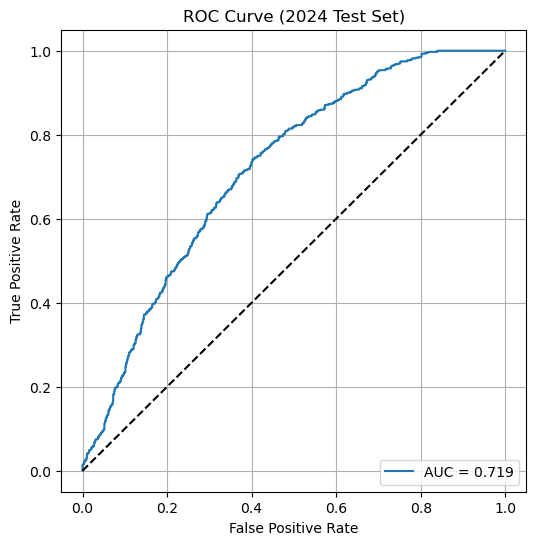

In [56]:
# model 2: value-based model

# ROC curve
fpr, tpr, _ = roc_curve(y_test_final, y_proba_test)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (2024 Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


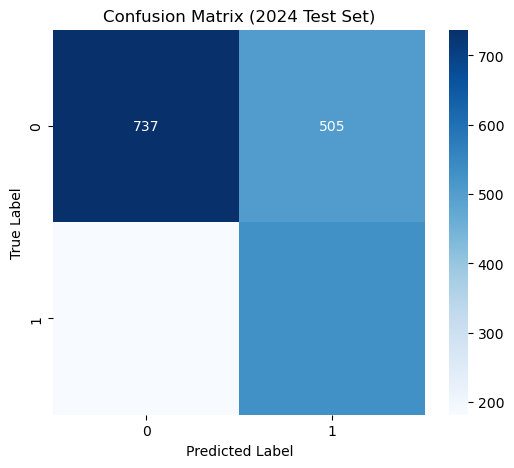

In [57]:
# model 2: value-based model

# Confusion Matrix
cm = confusion_matrix(y_test_final, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (2024 Test Set)")
plt.show()


In [58]:
### End: value-based logistic regression classifier model ###

In [59]:
### Begin: performance-based logistic regression classifier models ###

In [60]:
# model 3: peformance-based 

# apply the temporal lagging function
wr_model_perf_df = create_modeling_dataframe(wr_df, value_based_features)


In [61]:
# model 3: peformance-based 

# Define and prepare modeling dataframe
performance_features = [
    'rec_3wk_avg', 'rec_yds_5wk_avg', 'rec_air_yards_7wk_avg', 'tgt_3wk_avg',
    'tgt_3wk_delta', 'rec_3wk_delta', 'rec_yds_3wk_delta',
    'targets_75th_percentile_3wk', 'rec_75th_percentile_3wk', 'receiving_yards_75th_percentile_3wk',
    'rec_7wk_avg_z', 'rec_air_yards_7wk_avg_clipped_z', 'target_share_z'
]


In [62]:
# model 3: peformance-based 

# Redefine the target column using the modeling dataframe
fpts_threshold = 10
X = wr_model_perf_df[performance_features].copy()
y = (wr_model_perf_df['fpts'] >= fpts_threshold).astype(int)



In [63]:
# model 3: peformance-based 

# Add season info for splitting
X['season'] = wr_model_df['season']
y.index = X.index

# Split by season
X_train = X[X['season'] < 2023].drop(columns='season')
y_train = y[X['season'] < 2023]

X_val = X[X['season'] == 2023].drop(columns='season')
y_val = y[X['season'] == 2023]

X_test = X[X['season'] == 2024].drop(columns='season')
y_test = y[X['season'] == 2024]

In [64]:
# model 3: peformance-based 
# Train Baseline and Tuned Logistic Regression

# Baseline model (C=1)
logreg_model = LogisticRegression(C=1.0, penalty='l2', solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=42)
logreg_model.fit(X_train, y_train)

# Tuned model
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(
    estimator=LogisticRegression(penalty="l2", solver="lbfgs", class_weight="balanced", max_iter=1000, random_state=42),
    param_grid=param_grid,
    scoring="f1",
    cv=5
)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_


In [65]:
# model 3: peformance-based 
# Evaluate on Validation Set
print("📊 Baseline model (C=1):")
print(classification_report(y_val, logreg_model.predict(X_val)))

print("\n✅ Tuned model (best C):")
print(classification_report(y_val, best_model.predict(X_val)))

# Feature influence
coefficients = pd.Series(best_model.coef_[0], index=X_train.columns).sort_values(ascending=False)
print("\n🔍 Logistic Regression Coefficients:")
display(coefficients)


📊 Baseline model (C=1):
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      1921
           1       0.51      0.78      0.62       412

    accuracy                           0.83      2333
   macro avg       0.73      0.81      0.75      2333
weighted avg       0.87      0.83      0.84      2333


✅ Tuned model (best C):
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      1921
           1       0.51      0.78      0.61       412

    accuracy                           0.83      2333
   macro avg       0.73      0.81      0.75      2333
weighted avg       0.87      0.83      0.84      2333


🔍 Logistic Regression Coefficients:


receiving_yards_75th_percentile_3wk    1.262874
target_share_z                         0.873058
rec_75th_percentile_3wk                0.538803
rec_air_yards_7wk_avg_clipped_z        0.449838
rec_3wk_delta                          0.144293
rec_7wk_avg_z                          0.113229
rec_3wk_avg                            0.056507
rec_yds_3wk_delta                      0.033472
tgt_3wk_avg                            0.002140
rec_yds_5wk_avg                        0.000432
rec_air_yards_7wk_avg                 -0.009289
tgt_3wk_delta                         -0.107379
targets_75th_percentile_3wk           -0.179681
dtype: float64

In [66]:
# model 3: peformance-based 
# Generate Predictions and Probabilities
# Predict on test set
y_pred_test = best_model.predict(X_test)
y_proba_test = best_model.predict_proba(X_test)[:, 1]


In [67]:
# model 3: peformance-based 
# Classification Report and AUC

print("📅 Final Test Set (2024) Evaluation:")
print(classification_report(y_test, y_pred_test))

# AUC
auc_test = roc_auc_score(y_test, y_proba_test)
print(f"📈 ROC AUC (2024): {auc_test:.3f}")


📅 Final Test Set (2024) Evaluation:
              precision    recall  f1-score   support

           0       0.95      0.80      0.87      1734
           1       0.49      0.81      0.61       403

    accuracy                           0.80      2137
   macro avg       0.72      0.81      0.74      2137
weighted avg       0.86      0.80      0.82      2137

📈 ROC AUC (2024): 0.892


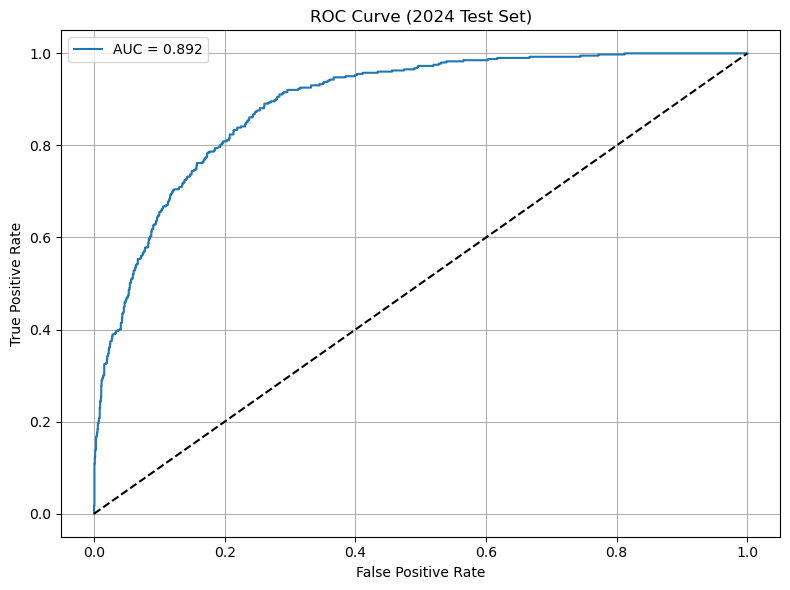

In [68]:
# model 3: peformance-based 
#  Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (2024 Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
### End: performance-based logistic regression classifier models ###

In [ ]:
### Begin: Random Forest Modeling ###

In [ ]:
### End: Random Forest Modeling ###